In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
from torchvision.datasets import ImageFolder
import torch



### Creating a neural net

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,5),
    torch.nn.Conv2d(16,32,5),
    torch.nn.Flatten(),
    torch.nn.Linear(18432,800),
    torch.nn.ReLU(),
    torch.nn.Linear(800,10),
    torch.nn.Softmax(dim=1)
).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)



In [3]:
train_data = ImageFolder(root="train", transform=transforms.ToTensor())
valid_path = ImageFolder(root="valid", transform=transforms.ToTensor())

In [4]:
bs = 4096
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_path, batch_size=bs, shuffle=True)

Epoch: 1 | Training Loss: 9483.3546 | Validation Loss: 9545.5163 | Training Accuracy: 12.57% | Validation Accuracy: 10.68%
Epoch: 2 | Training Loss: 9467.2020 | Validation Loss: 9188.4637 | Training Accuracy: 14.00% | Validation Accuracy: 20.83%
Epoch: 3 | Training Loss: 9089.6199 | Validation Loss: 8949.8902 | Training Accuracy: 23.21% | Validation Accuracy: 26.66%
Epoch: 4 | Training Loss: 8910.3606 | Validation Loss: 8858.5059 | Training Accuracy: 27.72% | Validation Accuracy: 29.23%
Epoch: 5 | Training Loss: 8790.0915 | Validation Loss: 8737.2233 | Training Accuracy: 30.75% | Validation Accuracy: 31.98%
Epoch: 6 | Training Loss: 8681.7704 | Validation Loss: 8643.6572 | Training Accuracy: 33.45% | Validation Accuracy: 34.60%
Epoch: 7 | Training Loss: 8597.8289 | Validation Loss: 8570.4985 | Training Accuracy: 35.76% | Validation Accuracy: 36.34%
Epoch: 8 | Training Loss: 8525.1844 | Validation Loss: 8504.3514 | Training Accuracy: 37.67% | Validation Accuracy: 38.06%
Epoch: 9 | Train

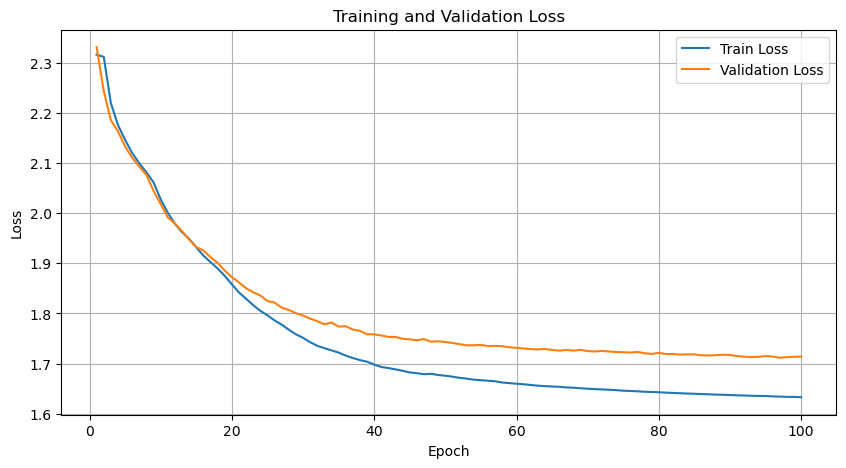

In [5]:

import matplotlib.pyplot as plt

train_losses = []  # List to store training losses for each epoch
valid_losses = []  # List to store validation losses for each epoch
epochs = 100
# Assuming you have a loop that runs for each epoch
# Initialize lists to store training and validation losses and accuracies
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# ...

for epoch in range(epochs):
    train_loss_sum = 0.0
    valid_loss_sum = 0.0
    correct_train = 0
    total_train = 0
    correct_valid = 0
    total_valid = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    net.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = loss_fn(output, labels)
            valid_loss_sum += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(output, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy for the entire epoch
    avg_train_loss = train_loss_sum / len(train_loader)
    avg_valid_loss = valid_loss_sum / len(valid_loader)
    train_accuracy = 100 * correct_train / total_train
    valid_accuracy = 100 * correct_valid / total_valid

    print(f"Epoch: {epoch+1} | Training Loss: {avg_train_loss*bs:.4f} | Validation Loss: {avg_valid_loss*bs:.4f} | Training Accuracy: {train_accuracy:.2f}% | Validation Accuracy: {valid_accuracy:.2f}%")
    
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



In [6]:
torch.save(net.state_dict(), "model.pth")

In [23]:
test_path = ImageFolder(root="te_st", transform=transforms.ToTensor())
test_loader = DataLoader(test_path, batch_size=bs, shuffle=False)

In [35]:
output_l = []
with torch.inference_mode():
    for images,_ in test_loader:
        images = images.to(device)
        output = net(images)
        for image in output:
            output_l.append(image.round().argmax().tolist())            

In [45]:
output_l = np.array(output_l)

class_dict = train_data.class_to_idx

# Create a DataFrame to map class indices to labels
class_mapping_df = pd.DataFrame(list(class_dict.items()), columns=['label','id'])

class_mapping_df.to_csv("submission.csv", index=False)
predicted_labels = class_mapping_df.loc[predictions, 'label'].tolist()
submission_df = pd.DataFrame({'id': list(range(1, len(predicted_labels)+1)), 'label': predicted_labels})

In [47]:
submission_df.to_csv("submission.csv", index=False)

In [48]:
submission_df.head()


,id,label
0,1,dog
1,2,dog
2,3,bird
3,4,deer
4,5,bird
